In [27]:
#import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Strategy Backtest Implementation

In [28]:
def mean_reverting_spread_strategy(asset1: str,
                                   asset2: str,
                                   spread: pd.Series, long_term_mean: float,
                                   std_window: int = 20,
                                   entry_threshold: float = 2,
                                   exit_threshold: float = -0.25,
                                   relaxed_exit: float = 1,
                                   ma_short_window: int = 5,
                                   ma_long_window: int = 20,
                                   min_start_index: int = 20,
                                   tolerance: float = 1):
    """
    Mean-reversion pairs trading strategy using a fixed mean and rolling volatility.

    Strategy Logic:
    - Enter long if z-score < -entry_threshold
    - Enter short if z-score > +entry_threshold
    - Exit if z-score crosses back within +/- exit_threshold
    - If holding a position over 180 days:
        - If spread is trending away (against position), force exit (stop-loss) and pause new trades
        - If trend is flat (no strong signal), allow exit with a relaxed threshold
    - After a forced exit, wait for spread to return near long-term mean before resuming trading

    Parameters:
    - spread: Series of spread values (e.g., KO - 0.27 * PEP)
    - long_term_mean: Precomputed fixed mean of the spread
    - std_window: Rolling window size for volatility (standard deviation)
    - entry_threshold: Z-score to enter a trade
    - exit_threshold: Z-score to exit a trade
    - ma_short_window: Rolling window for short-term mean (for trend detection)
    - ma_long_window: Rolling window for long-term mean (for trend detection)
    - min_start_index: Index to start backtesting after warm-up period
    - tolerance: Absolute z-score distance to resume trading after pause

    Returns:
    - trades: DataFrame of trade history
    - sharpe: Sharpe ratio of the strategy
    - max_drawdown: Maximum drawdown from cumulative PnL
    - profitability: Percentage of profitable trades
    """

    # Calculate z-score and moving averages
    rolling_std = spread.rolling(window=std_window).std()
    z_score = (spread - long_term_mean) / rolling_std
    spread_short_mean = spread.rolling(window=ma_short_window).mean()
    spread_long_mean = spread.rolling(window=ma_long_window).mean()

    # Plotting thresholds
    up_threshold = long_term_mean + entry_threshold * rolling_std
    down_threshold = long_term_mean - entry_threshold * rolling_std

    position = 0              # 0 = no position, 1 = long spread, -1 = short spread
    trade_log = []            # Store trade history
    signals = []              # Store visual signals
    paused = False            # If True, skip trade signals until spread mean-reverts

    for i in range(min_start_index, len(spread)):
        date = spread.index[i]
        if rolling_std[i] == 0 or np.isnan(rolling_std[i]):
            continue

        # Resume trading only if spread has reverted back near long-term mean
        if paused and abs(z_score[i]) < tolerance:
            paused = False

        # Entry logic (only if not paused)
        if position == 0 and not paused:
            if z_score[i] > entry_threshold:
                # Short the spread (KO expensive, PEP cheap)
                position = -1
                entry_price = spread[i]
                entry_date = date
                direction = f"Short {asset1} / Long {asset2}"
                signals.append((date, spread[i], 'sell'))
            elif z_score[i] < -entry_threshold:
                # Long the spread (KO cheap, PEP expensive)
                position = 1
                entry_price = spread[i]
                entry_date = date
                direction = f"Long {asset1} / Short {asset2}"
                signals.append((date, spread[i], 'buy'))

        elif position == 1:
            holding_days = (date - entry_date).days
            trend = spread_short_mean[i] - spread_long_mean[i]

            # Normal exit if z-score reverts
            if z_score[i] >= -exit_threshold:
                pnl = spread[i] - entry_price
                trade_log.append({
                    "Entry Date": entry_date,
                    "Exit Date": date,
                    "Direction": direction,
                    "Entry Spread": entry_price,
                    "Exit Spread": spread[i],
                    "PnL": pnl
                })
                position = 0

            # Stop-loss or relaxed exit after 180 days of holding
            elif holding_days > 150:
                if trend > 0:  # Trend is continuing in wrong direction → force stop
                    pnl = spread[i] - entry_price
                    trade_log.append({
                        "Entry Date": entry_date,
                        "Exit Date": date,
                        "Direction": direction,
                        "Entry Spread": entry_price,
                        "Exit Spread": spread[i],
                        "PnL": pnl
                    })
                    position = 0
                    paused = True
                elif abs(trend) < 0.01:  # Flat trend, allow relaxed exit
                    if z_score[i] >= -relaxed_exit:
                        pnl = spread[i] - entry_price
                        trade_log.append({
                            "Entry Date": entry_date,
                            "Exit Date": date,
                            "Direction": direction,
                            "Entry Spread": entry_price,
                            "Exit Spread": spread[i],
                            "PnL": pnl
                        })
                        position = 0

        elif position == -1:
            holding_days = (date - entry_date).days
            trend = spread_short_mean[i] - spread_long_mean[i]

            if z_score[i] <= exit_threshold:
                pnl = entry_price - spread[i]
                trade_log.append({
                    "Entry Date": entry_date,
                    "Exit Date": date,
                    "Direction": direction,
                    "Entry Spread": entry_price,
                    "Exit Spread": spread[i],
                    "PnL": pnl
                })
                position = 0

            elif holding_days > 150:
                if trend < 0:  # Wrong trend → stop-loss
                    pnl = entry_price - spread[i]
                    trade_log.append({
                        "Entry Date": entry_date,
                        "Exit Date": date,
                        "Direction": direction,
                        "Entry Spread": entry_price,
                        "Exit Spread": spread[i],
                        "PnL": pnl})
                    position = 0
                    paused = True
                elif abs(trend) < 0.01:  # Flat trend → allow relaxed exit
                    if z_score[i] <= relaxed_exit:
                        pnl = entry_price - spread[i]
                        trade_log.append({
                            "Entry Date": entry_date,
                            "Exit Date": date,
                            "Direction": direction,
                            "Entry Spread": entry_price,
                            "Exit Spread": spread[i],
                            "PnL": pnl
                        })
                        position = 0

    # Compute performance metrics
    trades = pd.DataFrame(trade_log)

    # Plot spread and signals
    plt.figure(figsize=(12, 6))
    plt.plot(spread, label="Spread", color='blue')
    plt.axhline(long_term_mean, color="black", linestyle="--", label="Fixed Mean")
    plt.plot(up_threshold, color="red", linestyle="--", label="Upper Threshold")
    plt.plot(down_threshold, color="green", linestyle="--", label="Lower Threshold")

    for date, val, sig in signals:
        if sig == 'buy':
            plt.scatter(date, val, color='green', marker='^', s=100,
                        label='Buy Signal' if 'Buy Signal' not in plt.gca().get_legend_handles_labels()[1] else "")
        elif sig == 'sell':
            plt.scatter(date, val, color='red', marker='v', s=100,
                        label='Sell Signal' if 'Sell Signal' not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.title("Spread Strategy with Fixed Mean, Rolling Std, Trend & Pause Logic")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return trades

In [29]:
def run_backtest(
    trades: pd.DataFrame,
    data1: pd.Series,
    data2: pd.Series,
    hedge_ratio: float,
    initial_capital: float = 100_000,
    default_trade_unit: float = 10_000
):
    """
    Simulate backtest with actual trade execution based on data1 (e.g., KO) and data2 (e.g., PEP) prices.

    Parameters:
    - trades: DataFrame of trade history
    - data1: price series of asset 1 (e.g., KO)
    - data2: price series of asset 2 (e.g., PEP)
    - hedge_ratio: weight applied to asset 2 (e.g., 0.27)
    - initial_capital: starting capital in USD
    - default_trade_unit: max dollar exposure per leg

    Returns:
    - metrics: performance dictionary
    - wealth_series: pd.Series of portfolio value over time
    """

    wealth = initial_capital
    wealth_history = [wealth]
    wealth_dates = [data1.index[0]]

    for _, trade in trades.iterrows():
        entry_date = pd.to_datetime(trade["Entry Date"])
        exit_date = pd.to_datetime(trade["Exit Date"])
        direction = trade["Direction"]

        # Get prices at entry and exit
        entry_price1 = data1.loc[entry_date]
        entry_price2 = data2.loc[entry_date]
        exit_price1 = data1.loc[exit_date]
        exit_price2 = data2.loc[exit_date]

        # Capital-based trade sizing
        max_units1 = wealth // entry_price1
        max_units2 = wealth // entry_price2
        trade_unit = min(default_trade_unit, max_units1, max_units2)

        # PnL based on trade direction
        if "Long" in direction:
            pnl = ((exit_price1 - entry_price1) + (entry_price2 - exit_price2) * hedge_ratio) * trade_unit
        else:
            pnl = ((entry_price1 - exit_price1) + (exit_price2 - entry_price2) * hedge_ratio) * trade_unit

        wealth += pnl
        wealth_history.append(wealth)
        wealth_dates.append(exit_date)

    wealth_series = pd.Series(wealth_history, index=pd.to_datetime(wealth_dates)).sort_index()

    # Metrics
    final_wealth = wealth_series.iloc[-1]
    days = (wealth_series.index[-1] - wealth_series.index[0]).days
    annual_return = (final_wealth / initial_capital) ** (252 / days) - 1 if days > 0 else np.nan
    daily_returns = wealth_series.pct_change().dropna()
    sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if len(daily_returns) > 1 else np.nan
    peak = wealth_series.cummax()
    max_drawdown = ((peak - wealth_series) / peak).max()

    win_ratio = (trades["PnL"] > 0).mean() if not trades.empty else np.nan
    total_gain = trades.loc[trades["PnL"] > 0, "PnL"].sum()
    total_loss = -trades.loc[trades["PnL"] < 0, "PnL"].sum()
    profitability = total_gain / total_loss if total_loss > 0 else np.nan

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(wealth_series, label='Cumulative Wealth', color='darkblue')
    plt.title(f"Cumulative Wealth | Final: ${final_wealth:,.2f}")
    plt.xlabel("Date")
    plt.ylabel("Wealth ($)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    metrics = {
        "Final Wealth": final_wealth,
        "Annual Return (%)": annual_return,
        "Sharpe Ratio (daily)": sharpe_ratio,
        "Max Drawdown (%)": max_drawdown,
        "Win Ratio": win_ratio,
        "Profitability (Gain/Loss Ratio)": profitability,
        "Total Trades": len(trades)
    }

    print("\n📊 Performance Summary:")
    for k, v in metrics.items():
        if isinstance(v, float):
            print(f"{k}: {v:.2%}" if "%" in k else f"{k}: {v:,.4f}")
        else:
            print(f"{k}: {v}")

    return metrics, wealth_series


## Stock pair trading

In [30]:
data = pd.read_csv("KO_PEP_close_2012_2025.csv", 
    header=[0, 1], 
    skiprows=[2], 
    index_col=0, 
    parse_dates=True )
stock1 = 'KO'
stock2 = 'PEP'
prices_data = data[[('Close', stock1), ('Close', stock2)]]
prices_data.columns = [stock1, stock2]
prices_data

,KO,PEP
2012-01-03,23.253370,45.088364
2012-01-04,23.107504,45.319256
2012-01-05,22.998095,44.966137
2012-01-06,22.852228,44.402542
2012-01-09,22.852228,44.633423
...,...,...
2024-12-24,62.379669,151.470779
2024-12-26,62.111645,151.104019
2024-12-27,61.992527,151.550079
2024-12-30,61.575600,150.390335


In [31]:
# Parameters
start_date = "2022-01-01"
end_date = "2025-01-01"
hedge_ratio = 0.27
test_data = prices_data.loc['2012-01-01':start_date]
test_spread = test_data[stock1] - hedge_ratio * test_data[stock2]
long_term_mean = test_spread.mean()

# Download historical data
backtest_data = prices_data.loc[start_date:end_date]
data1 = backtest_data[stock1] #yf.download("KO", start=start_date, end=end_date)["Adj Close"]
data2 = backtest_data[stock2]

# Calculate spread using hedge ratio
spread = data1 - hedge_ratio * data2

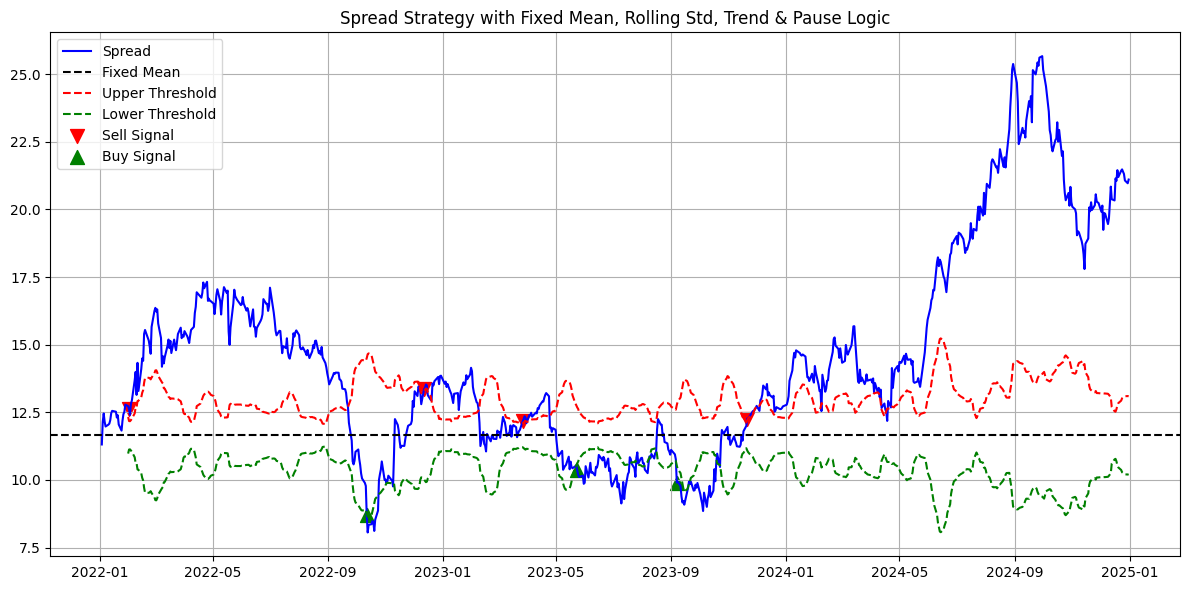

,Entry Date,Exit Date,Direction,Entry Spread,Exit Spread,PnL
2,2022-12-12,2023-02-10,Short KO / Long PEP,13.357421,11.254162,2.103259
3,2023-03-27,2023-05-02,Short KO / Long PEP,12.173902,11.438421,0.735482
4,2023-05-24,2023-08-17,Long KO / Short PEP,10.361161,11.859510,1.498349
5,2023-09-07,2023-10-31,Long KO / Short PEP,9.904561,11.961595,2.057034
6,2023-11-21,2024-04-22,Short KO / Long PEP,12.269983,12.681175,-0.411192


In [32]:
trades = mean_reverting_spread_strategy(
    asset1=stock1,
    asset2=stock2,
    spread=spread,
    long_term_mean=long_term_mean,
)

trades.tail(5)

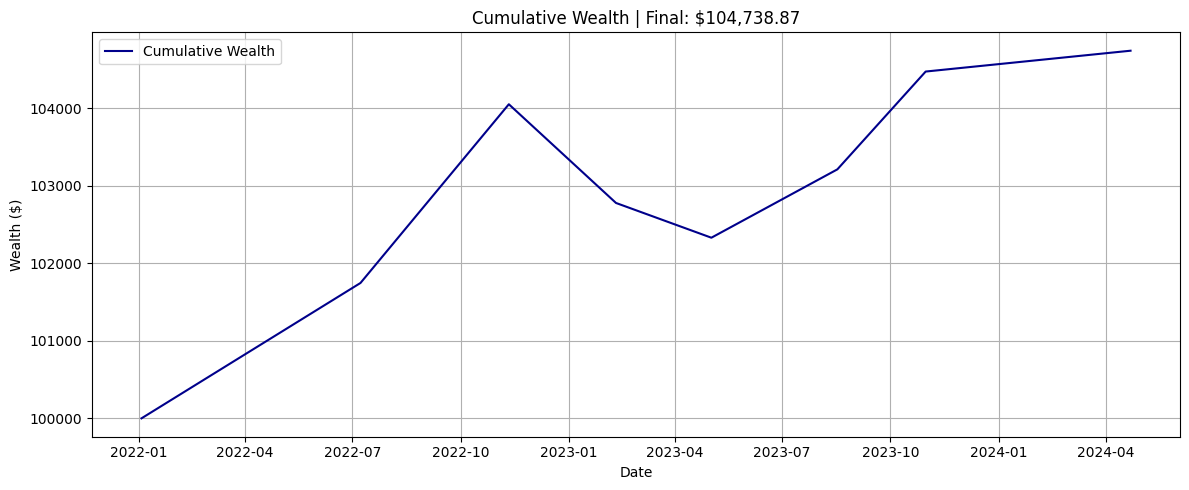


📊 Performance Summary:
Final Wealth: 104,738.8678
Annual Return (%): 1.40%
Sharpe Ratio (daily): 8.6775
Max Drawdown (%): 1.65%
Win Ratio: 0.7143
Profitability (Gain/Loss Ratio): 3.1639
Total Trades: 7


In [34]:
metrics, wealth_series = run_backtest(
    trades = trades,
    data1 = data1, 
    data2 = data2,
    hedge_ratio=0.27,
    initial_capital=100000,
    default_trade_unit=1000
)

## ETF pair trading

In [35]:
data = pd.read_csv("etf_2012_2025.csv", 
    header=[0, 1], 
    skiprows=[2], 
    index_col=0, 
    parse_dates=True )
etf1 = 'XLF'
etf2 = 'IYR'
prices_data = data[[('Close', etf1), ('Close', etf2)]]
prices_data.columns = [etf1, etf2]
prices_data

,XLF,IYR
2012-01-03,8.469131,36.913578
2012-01-04,8.443736,36.500259
2012-01-05,8.558014,36.765034
2012-01-06,8.507222,36.700470
2012-01-09,8.551661,36.597145
...,...,...
2024-12-24,48.812702,93.061127
2024-12-26,48.932266,93.250412
2024-12-27,48.573570,92.323883
2024-12-30,48.105270,91.935341


In [36]:
# Parameters
start_date = "2022-01-01"
end_date = "2025-01-01"
test_data = prices_data.loc['2012-01-01':start_date]
hedge_ratio = 0.45
test_spread = test_data[etf1] - hedge_ratio * test_data[etf2]
long_term_mean = test_spread.mean()

# Download historical data
backtest_data = prices_data.loc[start_date:end_date]
data1 = backtest_data[etf1] #yf.download("KO", start=start_date, end=end_date)["Adj Close"]
data2 = backtest_data[etf2]

# Calculate spread using hedge ratio
spread = data1 - hedge_ratio * data2

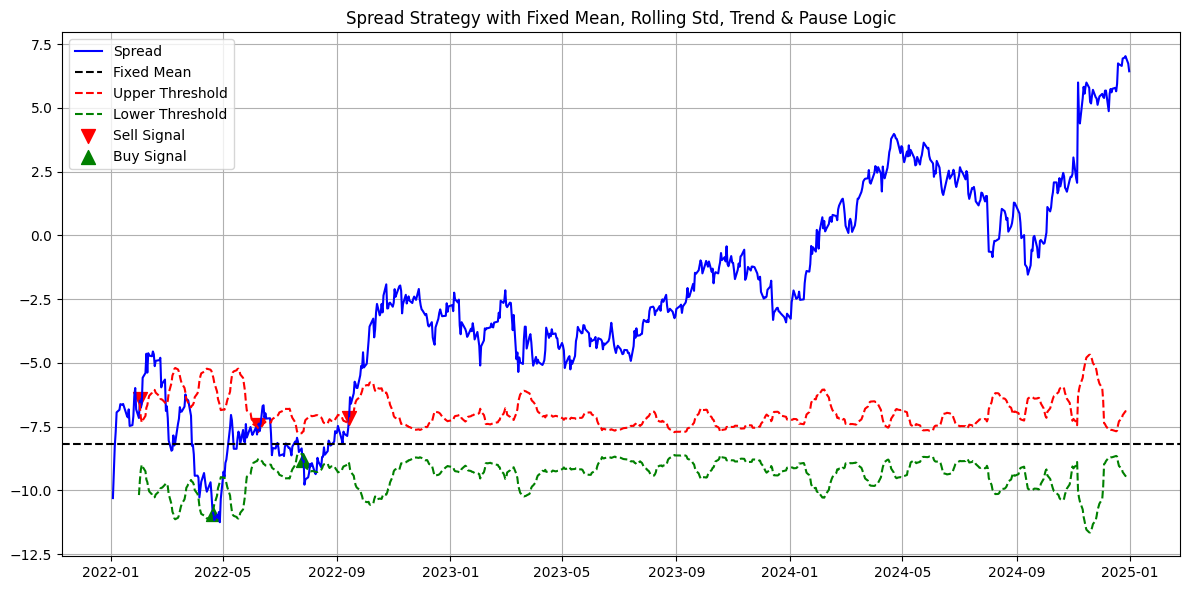

In [38]:
trades = mean_reverting_spread_strategy(
    asset1=etf1,
    asset2=etf2,
    spread=spread,
    long_term_mean=long_term_mean,
)

In [39]:
trades.tail(5)

,Entry Date,Exit Date,Direction,Entry Spread,Exit Spread,PnL
0,2022-02-01,2022-03-31,Short XLF / Long IYR,-6.412049,-8.584177,2.172128
1,2022-04-21,2022-05-09,Long XLF / Short IYR,-10.924137,-7.527618,3.396519
2,2022-06-08,2022-06-23,Short XLF / Long IYR,-7.452415,-8.622137,1.169722
3,2022-07-26,2022-08-23,Long XLF / Short IYR,-8.818950,-8.051045,0.767905
4,2022-09-14,2023-03-13,Short XLF / Long IYR,-7.165044,-4.857636,-2.307409


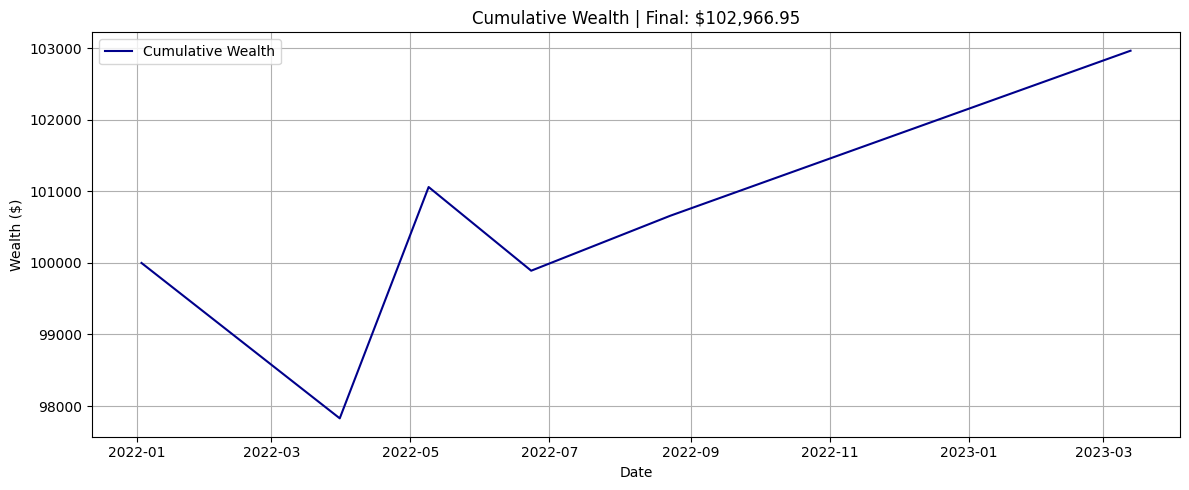


📊 Performance Summary:
Final Wealth: 102,966.9491
Annual Return (%): 1.71%
Sharpe Ratio (daily): 4.2095
Max Drawdown (%): 2.17%
Win Ratio: 0.8000
Profitability (Gain/Loss Ratio): 3.2531
Total Trades: 5


In [40]:
metrics, wealth_series = run_backtest(
    trades = trades,
    data1 = data1, 
    data2 = data2,
    hedge_ratio=0.45,
    initial_capital=100000,
    default_trade_unit=1000
)